<a href="https://colab.research.google.com/github/shashankiitbhu/Agora-Android/blob/master/final_MIC_AgNP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nanoparticle Toxicity Modeling and Interpretability Analysis**


This repository contains a complete data analysis pipeline for modeling and interpreting silver nanoparticle (AgNP) toxicity. The project predicts the Minimum Inhibitory Concentration (MIC) based on AgNP physicochemical properties (size, shape, synthesis method) and the target bacterium's Gram stain.

The XGBoost (eXtreme Gradient Boosting) model is chosen for its high accuracy on complex and non-linear data. Model interpretability is achieved using SHAP (SHapley Additive exPlanations) to understand why the model makes its predictions.

This project moves beyond simple feature importance to explore:
* Deep Non-Linear Effects: How does toxicity really change with size?
* Feature Interactions: How does synthesis method change the effect of size?
* Conditional Toxicity: Do the rules for toxicity change completely between Gram-Positive and Gram-Negative bacterial populations?


# Data Source & Citation

This analysis utilizes a publicly available dataset on AgNP toxicity and predictive modeling. It consolidates data on size, shape, synthesis method, and MIC across various bacterial strains.

***Full Citation:***   
Aguilar-Garay, R., Lara-Ortiz, L. F., Campos-López, M., Gonzalez-Rodriguez, D. E., Gamboa-Lugo, M. M., Mendoza-Pérez, J. A., ... & Nicolás-Álvarez, D. E. (2024). A comprehensive review of silver and gold nanoparticles as effective antibacterial agents. Pharmaceuticals, 17(9), 1134.


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

from xgboost import XGBRegressor

# **Cleaning the dataset**

First, we load the Ag_MIC_Database.csv file. Then used the helper functions to clean the Size (nm) and MIC (μg/mL) columns, and categorized the Synthesis Method column. We drop any rows with missing essential data


In [ ]:
import pandas as pd
data = pd.read_csv("Ag_MIC_Database.csv")
print(data.head())

def extract_numeric_size(x):
    if pd.isna(x): return np.nan
    x = str(x)
    if '±' in x: return float(x.split('±')[0])
    if '-' in x:
        nums = re.findall(r'\d+\.?\d*', x)
        return np.mean(list(map(float, nums))) if nums else np.nan
    match = re.findall(r'\d+\.?\d*', x)
    return float(match[0]) if match else np.nan

def extract_mic(x):
    if pd.isna(x): return np.nan
    x = str(x).replace('>', '').replace('<', '').replace('~', '')
    match = re.findall(r'\d+\.?\d*', x)
    return float(match[0]) if match else np.nan

def simplify_synthesis_method(x):
    x = str(x).lower()
    if 'plant' in x or 'extract' in x or 'bio' in x: return 'green'
    if 'chemical' in x or 'reduction' in x: return 'chemical'
    if 'physical' in x: return 'physical'
    return 'unspecified'

def rmse_log(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

data['Size (nm)'] = data['Size (nm)'].apply(extract_numeric_size)
data['MIC (μg/mL)'] = data['MIC (μg/mL)'].apply(extract_mic)
data['Synthesis Method'] = data['Synthesis Method'].astype(str).apply(simplify_synthesis_method)

data = data[['Size (nm)', 'Shape', 'Synthesis Method', 'Gram +/-', 'MIC (μg/mL)']].dropna(subset=['MIC (μg/mL)', 'Size (nm)'])

print("Data shape after cleaning:", data.shape)

  Nanoparticle Size (nm)      Shape                            Bacterium  \
0         AgNP      16±6  Irregular   Citrobacter amalonaticus UPMR bio1   
1         AgNP      16±6  Spherical              Pseudomonas sp UPMR 040   
2         AgNP      16±6  Spherical  Citrobacter agriculturist UPMR bio2   
3         AgNP      16±6  Spherical     Acinetobacter brisouii UPMR Skb1   
4         AgNP      16±6  Spherical           Bacillus pumilus UMPR Skb2   

  Gram +/- MIC (μg/mL)                                   Synthesis Method  \
0        -          40  Unspecified, purchased and purified by Nano Na...   
1        -          40  Unspecified, purchased and purified by Nano Na...   
2        -          40  Unspecified, purchased and purified by Nano Na...   
3        -          40  Unspecified, purchased and purified by Nano Na...   
4        +          40  Unspecified, purchased and purified by Nano Na...   

  Reagent Used  Year of study                                Link  
0  Unspecifi

# **Feature Engineering**
We split the data into features (X) and target (y). To handle the highly skewed distribution of MIC values (a common biological phenomenon), we apply a $\log_{10}$ transformation to the target variable y. This helps the model learn more effectively.

We also calculate the mean of this log-transformed target, main_base_score. This is a critical fix to prevent a known compatibility issue between XGBoost and SHAP


In [ ]:
X = data.drop('MIC (μg/mL)', axis=1)
y = data['MIC (μg/mL)']

categorical_features = ['Shape', 'Synthesis Method', 'Gram +/-']
numeric_features = ['Size (nm)']

preprocessor_tree = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

main_base_score = float(y_train_log.mean())

# **XGBoost tuning and evaluation**
We create a Pipeline that first preprocesses the data and then feeds it into an XGBRegressor. We use RandomizedSearchCV to tune the model's hyperparameters, explicitly passing our main_base_score to the regressor to ensure SHAP compatibility. Finally, we evaluate the tuned model using RMSE and R² on the log-transformed test data.

# Model Performance

* R² ($\approx 0.70$): The model explains nearly 70% of the variance in the log-transformed MIC values, which is a high level of accuracy for complex, real-world biological data.
* Residual Plot: The scatter plot of Predicted vs. Actual MIC shows a strong linear trend along the red $y=x$ line. The scatter is slightly higher at large MIC values, indicating the model is more certain in predicting high-toxicity (low MIC) outcomes.



Best Parameters Found: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.7}

 XGBoost Model Performance (log space): RMSE=0.349, R²=0.699


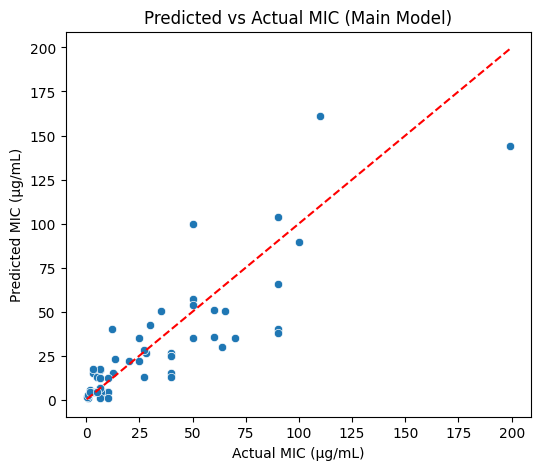

In [ ]:
param_dist = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

rmse_scorer = make_scorer(rmse_log)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBRegressor(objective='reg:squarederror', random_state=42, base_score=main_base_score)
search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, scoring=rmse_scorer, cv=cv, n_jobs=-1, random_state=42, verbose=0)

xgb_pipe = Pipeline([
    ('preprocess', preprocessor_tree), ('model', search)
])

xgb_pipe.fit(X_train, y_train_log)

best_params = search.best_params_
print("\nBest Parameters Found:", best_params)

y_pred_log = xgb_pipe.predict(X_test)
rmse_log_val = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log_val = r2_score(y_test_log, y_pred_log)

y_pred = np.power(10, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n XGBoost Model Performance (log space): RMSE={rmse_log_val:.3f}, R²={r2_log_val:.3f}")

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual MIC (μg/mL)")
plt.ylabel("Predicted MIC (μg/mL)")
plt.title("Predicted vs Actual MIC (Main Model)")
plt.show()

# **SHAP Analysis**
Now we "open the black box" using shap.TreeExplainer. The SHAP summary plot ranks features by their total impact on the model's output.

*   Positive SHAP value: Pushes the predicted MIC higher (lower toxicity).
*   Negative SHAP value: Pushes the predicted MIC lower (higher toxicity).

# Interpretation:

*   Size (nm): The most important feature. The plot clearly shows a trend: high feature values (large size, red dots) produce positive SHAP values, while low feature values (small size, blue dots) produce negative SHAP values.
*   Synthesis Method_chemical: The second most important. High values (i.e., the method is chemical, red dots) are strongly associated with positive SHAP values, indicating chemical synthesis is a primary driver of high MIC.
*   Shape_Cubic: The most influential of all shapes. A high value (red dots) is associated with positive SHAP values, suggesting cubic geometry contributes to high MIC.


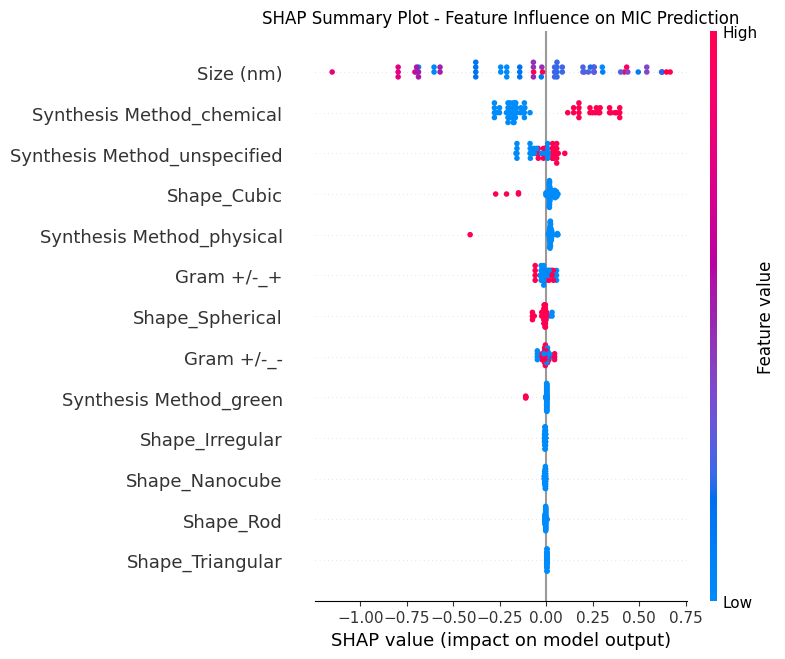

In [ ]:
model_stage = xgb_pipe.named_steps['model'].best_estimator_
ohe = xgb_pipe.named_steps['preprocess'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([cat_names, numeric_features])

X_test_transformed = xgb_pipe.named_steps['preprocess'].transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

if not isinstance(model_stage.base_score, float): model_stage.base_score = main_base_score

explainer = shap.TreeExplainer(model_stage)
shap_values = explainer.shap_values(X_test_transformed)

# SHAP Summary Plot
plt.figure()
plt.title("SHAP Summary Plot - Feature Influence on MIC Prediction")
shap.summary_plot(shap_values, X_test_transformed_df, feature_names=feature_names, show=False)
plt.show()

# **Alternative models**
To confirm the complexity of the data, we test several other model types. We must create a new preprocessor (preprocessor_scaled) that scales numeric features, as linear models (Lasso, Ridge) and SVR are sensitive to feature scale.

# Interpretation:

The results are stark. The linear models (Lasso, Ridge) and SVR completely fail to model the data (R² ≈ 0.0 or negative). This provides strong proof that the relationship between nanoparticle features and toxicity is highly non-linear. The superior performance of XGBoost and Random Forest is justified.

In [ ]:
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

pipe_rf = Pipeline([('preprocess', preprocessor_tree), ('model', RandomForestRegressor(n_estimators=100, random_state=42))])
pipe_lasso = Pipeline([('preprocess', preprocessor_scaled), ('model', Lasso(alpha=0.1, random_state=42))])
pipe_ridge = Pipeline([('preprocess', preprocessor_scaled), ('model', Ridge(alpha=1.0, random_state=42))])
pipe_svr = Pipeline([('preprocess', preprocessor_scaled), ('model', SVR(kernel='rbf'))])

models = {
    "Random Forest": pipe_rf,
    "Lasso Regression": pipe_lasso,
    "Ridge Regression": pipe_ridge,
    "Support Vector (SVR)": pipe_svr
}

for name, pipe in models.items():
    pipe.fit(X_train, y_train_log)
    y_pred_log = pipe.predict(X_test)
    rmse_log_val = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
    r2_log_val = r2_score(y_test_log, y_pred_log)
    print(f"\n{name} Performance (log space): RMSE={rmse_log_val:.3f}, R²={r2_log_val:.3f}")


Random Forest Performance (log space): RMSE=0.378, R²=0.648

Lasso Regression Performance (log space): RMSE=0.633, R²=0.011

Ridge Regression Performance (log space): RMSE=0.635, R²=0.007

Support Vector (SVR) Performance (log space): RMSE=0.673, R²=-0.115


# **Sub-Population Analysis**
This is the most critical scientific finding. We train two new, independent XGBoost models: one using only Gram-Negative data, and one using only Gram-Positive data. The same best_params from the main model is used for consistency.

# Interpretation

The results show a common trend for both the populations, indicating physicochemical propoerties of the silver nanoparticles do not affect their mechanism of action against Gram-positive and Gram-negative bacterias.



Performance Gram-Negative (log space): RMSE=0.388, R²=0.674


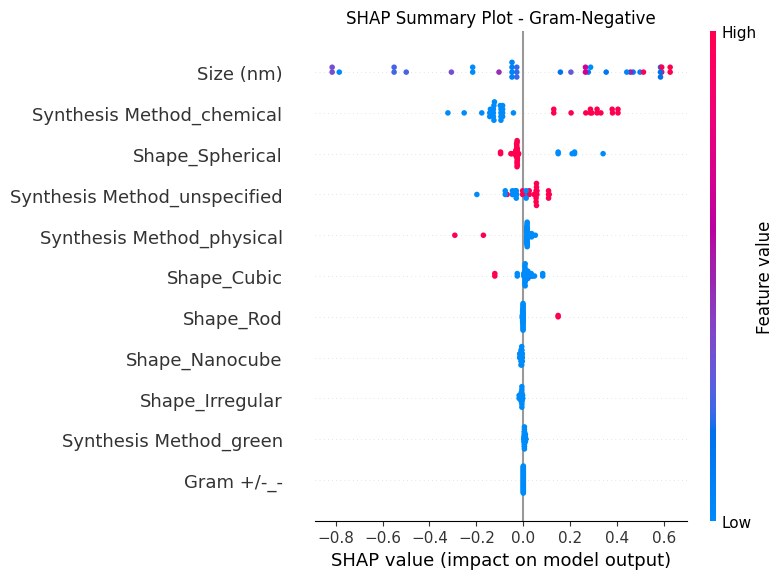

Performance Gram-Positive (log space): RMSE=0.443, R²=0.645


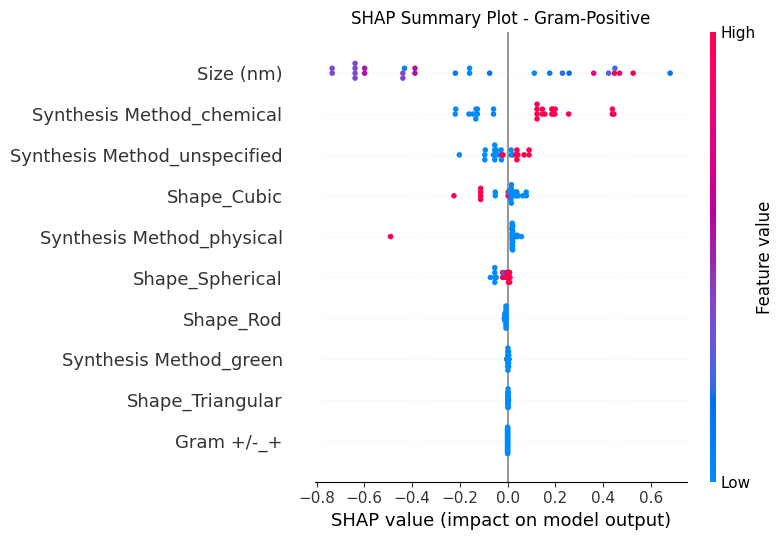

In [ ]:
def train_sub_model(sub_data, group_name):
    if sub_data.shape[0] < 50:
      print(f"Skipping {group_name}, not enough data samples ({sub_data.shape[0]})")
      return None

    X_sub = sub_data.drop('MIC (μg/mL)', axis=1)
    y_sub = sub_data['MIC (μg/mL)']

    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(
        X_sub, y_sub, test_size=0.2, random_state=42
    )

    if X_sub_train.empty:
        print(f"Skipping {group_name}, train split is empty.")
        return None

    y_sub_train_log = np.log10(y_sub_train)
    y_sub_test_log = np.log10(y_sub_test)

    sub_base_score = float(y_sub_train_log.mean())

    sub_preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)],
        remainder='passthrough'
    )

    sub_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, base_score=sub_base_score, **best_params)

    sub_pipe = Pipeline([
        ('preprocess', sub_preprocessor),
        ('model', sub_xgb)
    ])

    sub_pipe.fit(X_sub_train, y_sub_train_log)

    y_sub_pred_log = sub_pipe.predict(X_sub_test)
    rmse_log_val = np.sqrt(mean_squared_error(y_sub_test_log, y_sub_pred_log))
    r2_log_val = r2_score(y_sub_test_log, y_sub_pred_log)

    print(f"Performance {group_name} (log space): RMSE={rmse_log_val:.3f}, R²={r2_log_val:.3f}")

    sub_ohe = sub_pipe.named_steps['preprocess'].named_transformers_['cat']
    sub_cat_names = sub_ohe.get_feature_names_out(categorical_features)
    sub_feature_names = np.concatenate([sub_cat_names, numeric_features])

    X_sub_test_transformed = sub_pipe.named_steps['preprocess'].transform(X_sub_test)
    sub_model_stage = sub_pipe.named_steps['model']

    if not isinstance(sub_model_stage.base_score, float):
        sub_model_stage.base_score = sub_base_score

    sub_explainer = shap.TreeExplainer(sub_model_stage)
    sub_shap_values = sub_explainer.shap_values(X_sub_test_transformed)

    plt.figure()
    plt.title(f"SHAP Summary Plot - {group_name}")
    shap.summary_plot(sub_shap_values, pd.DataFrame(X_sub_test_transformed, columns=sub_feature_names), feature_names=sub_feature_names, show=False)
    plt.show()

    return sub_pipe

data_neg = data[data['Gram +/-'] == '-'].copy()
data_pos = data[data['Gram +/-'] == '+'].copy()

model_neg = train_sub_model(data_neg, 'Gram-Negative')
model_pos = train_sub_model(data_pos, 'Gram-Positive')